<table>
  <tr>
    <td><div align="left"><font size="30">Event camera demo</font></div></td>
    <td><img src="https://github.com/Tobias-Fischer/RVSS2022/blob/main/Robotic_Vision/common/RVSS-logo.png?raw=1" width="400"></td>
  </tr>
</table>

**By Cedric Scheerlinck; edited, expanded and adapted for RVSS2022 by Tobias Fischer**

Description: Let's explore event cameras. We will load a small dataset to get familiar with the event data structure, and display some popular visualisations. We will also see what happens if we integrate over the events directly, or with a leaky integrator. Finally, we will explore a promising direction where conventional frames are fused with the event data using a so-called complementarity filter.

This notebook is based on: https://github.com/cedric-scheerlinck/dvs_image_reconstruction  

In [ ]:
# If you are interested to find out more, check out this video by Cedric!

from IPython.display import YouTubeVideo
YouTubeVideo('bZ0ZKido0Ag')

## What are event cameras?

Event cameras are bio-inspired (mimicking the human eye) cameras that work fundamentally different from conventional cameras.

Let's first remember conventional image representation:

<img src="https://edtech.engineering.utoronto.ca/sites/default/files/M6_2DImageDigitalRepresentation.png" width="700">
(image courtesy University of Toronto)

In event cameras, each pixel operates independently. Rather than capturing the whole scene at fixed time intervals, only changes in the scene are observed. The output is a list of events $\mathbf{e}_i=(x_i, y_i, t_i, p_i)$ where the times $t_i$ have microsecond resolution, and $p_i=\{-1,+1\}$.

Conventional cameras sample the scene in fixed time intervals, which is the same for all pixels (image courtesy Guillermo Gallego):

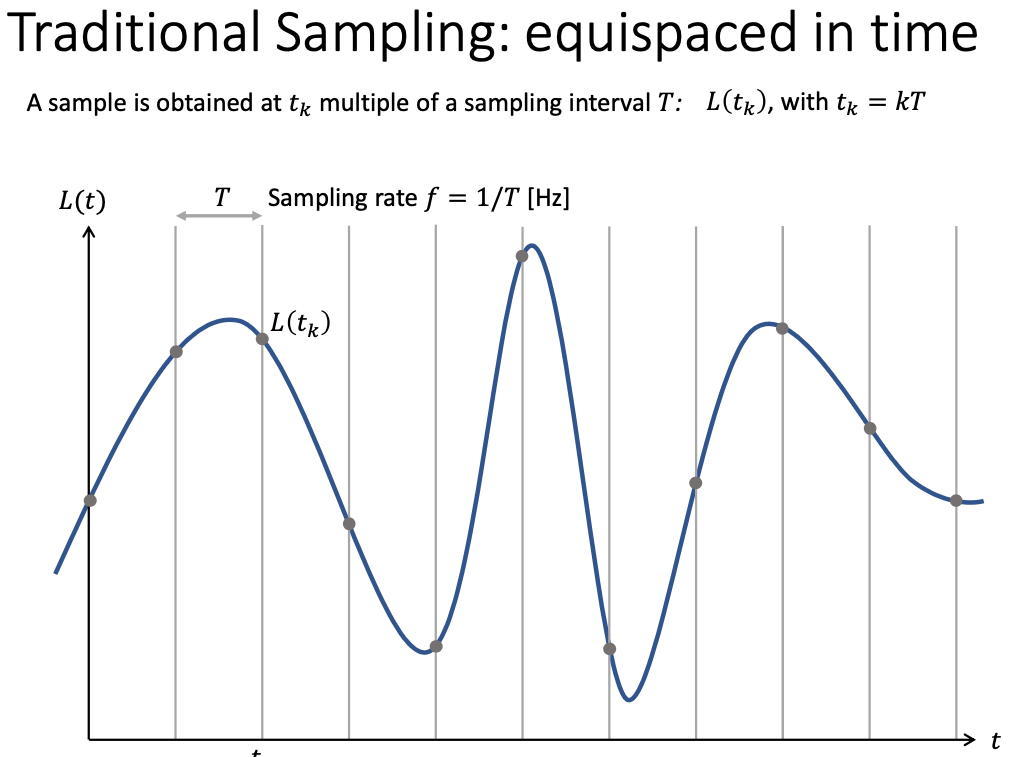

Event camera sampling is equispaced in range, and each pixel operates independently (image courtesy Guillermo Gallego)

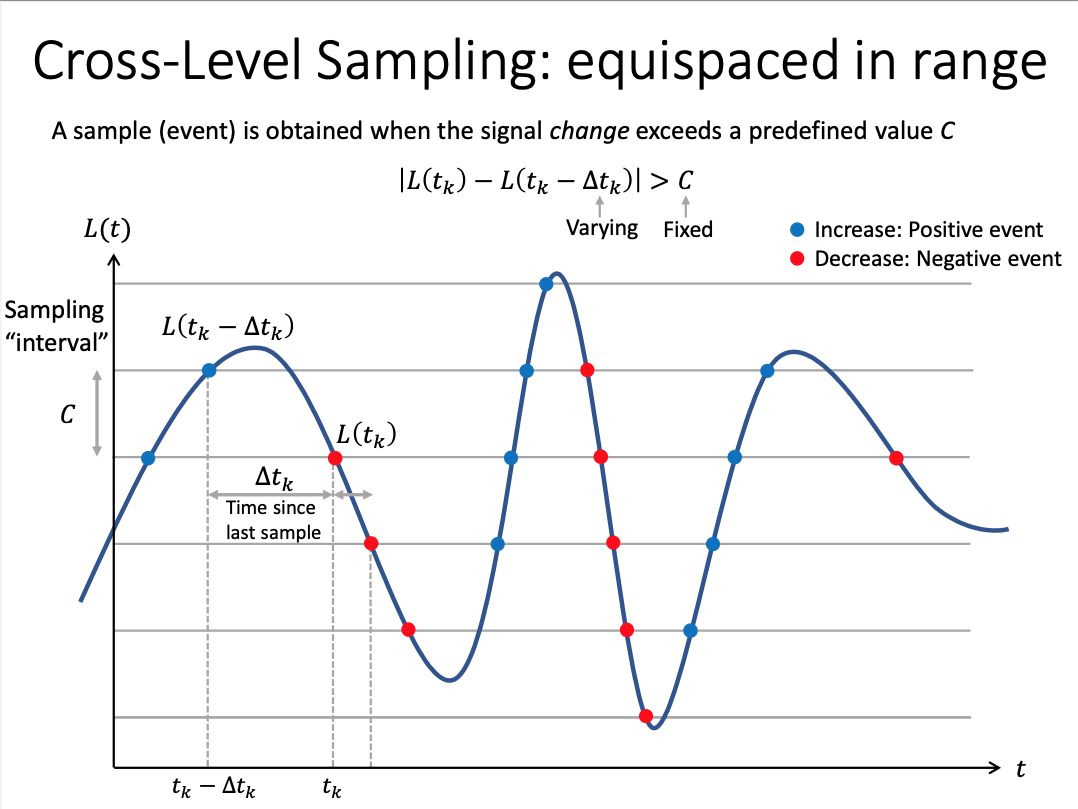

In [ ]:
# Let's see what that looks like in practise (video courtesy Hanme Kim, Imperial College London):

from IPython.display import YouTubeVideo
YouTubeVideo('kPCZESVfHoQ')

### Advantages of event cameras
There are three main advantages of using event cameras:

1.   High dynamic range (observing a scene that is very bright in one part, and very dark in another)


In [ ]:
# Solar eclipse captured with an event camera, credit M. Osswald, T. Delbruck and S. Bamford

from IPython.display import YouTubeVideo
YouTubeVideo('hQI7e1TpXmA')

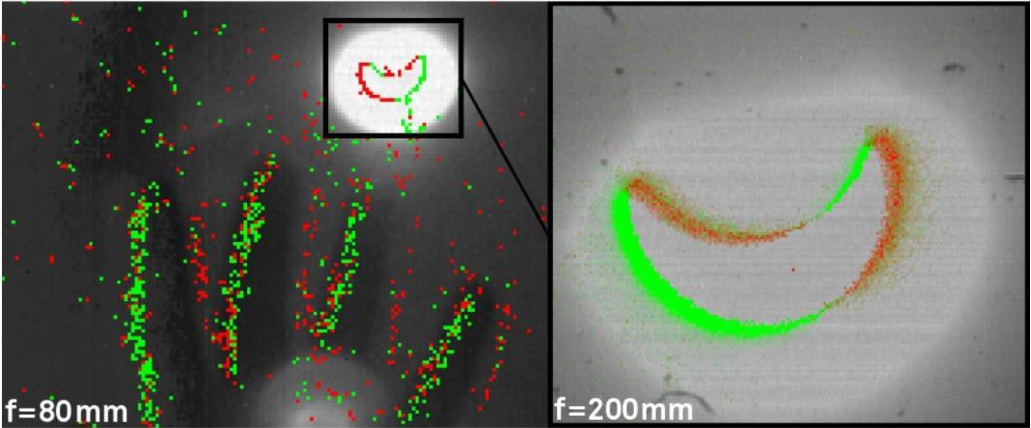

2.   Low latencies
3.   Basically no motion blur -> really well suited for high-speed scenarios
4.   Very low energy consumption

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('eomALySSGVU')

### Challenges
 - We need to rethink how we process the event footage. Computer vision has worked with conventional images for decades, but we can't easily apply the algorithms we know work well (including deep nets) with the completely different representation.
 - The hardware is not quite yet there and not yet mature
 - We only observe change, but don't have a sense of the scene intensity at $t=0$

### Notebook setup

In [ ]:
import os
# Let's get ready, we need the repo for some helper scripts
if not os.path.exists('RVSS2022'):
  !git clone --depth 1 https://github.com/Tobias-Fischer/RVSS2022.git
else:
  %cd RVSS2022
  !git pull
  %cd ..

In [ ]:
import sys
sys.path.insert(0, os.path.abspath('RVSS2022/Robotic_Vision/common'))

from ipywidgets import interact, fixed, interact_manual, FloatSlider, IntSlider
import math
%matplotlib inline
from matplotlib import rc
rc('animation', html='jshtml')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.core.display import display, HTML, Image

# local modules
from util import Timer, Event, normalize_image, animate, load_events, plot_3d, event_slice

### Filters + leaky integerator implementation

In [ ]:
def high_pass_filter(event_data, cutoff_frequency=5):
    print('Reconstructing, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    events_per_frame = 2e4
    with Timer('Reconstruction'):
        time_surface = np.zeros((height, width), dtype=np.float32)
        image_state = np.zeros((height, width), dtype=np.float32)
        image_list = []
        for i, e in enumerate(events):
            beta = math.exp(-cutoff_frequency * (e.t - time_surface[e.y, e.x]))
            image_state[e.y, e.x] = beta * image_state[e.y, e.x] + e.p
            time_surface[e.y, e.x] = e.t
            if i % events_per_frame == 0:
                beta = np.exp(-cutoff_frequency * (e.t - time_surface))
                image_state *= beta
                time_surface.fill(e.t)
                image_list.append(np.copy(image_state))
    return animate(image_list, 'High Pass Filter')

def leaky_integrator(event_data, beta=1.0):
    print('Reconstructing, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    events_per_frame = 2e4
    with Timer('Reconstruction (simple)'):
        image_state = np.zeros((height, width), dtype=np.float32)
        image_list = []
        for i, e in enumerate(events):
            # Note the beta here. If set to 1, we directly integrate.
            image_state[e.y, e.x] = beta * image_state[e.y, e.x] + e.p
            if i % events_per_frame == 0:
                image_list.append(np.copy(image_state))
    fig_title = 'Direct Integration' if beta == 1 else 'Leaky Integrator'
    return animate(image_list, fig_title)


### Let's load the event data and have a look at their representation

In [ ]:
with Timer('Loading'):
    n_events = 5e5
    path_to_events = 'RVSS2022/Robotic_Vision/event_camera_data/boxes_6dof/events.zip'
    event_data = load_events(path_to_events, n_events)        

In [ ]:
event_data.event_list[:10]

## Event point cloud

<span style="color:red">Red = ON event (+1),</span> <span style="color:blue">blue = OFF event (-1).</span>  
Click and drag the 3D plot to rotate it.

In [ ]:
with Timer('3D plot'):
    plot_3d(event_data, n_events=10e3)

## Event slice

Use the sliders to visualize a slice of events within a time window.

In [ ]:
interact(event_slice, event_data=fixed(event_data),
         start=FloatSlider(min=0, max=1, step=0.01,continuous_update=False),
         duration_ms=IntSlider(value=50, min=0, max=500, step=1, continuous_update=False));

## Image reconstruction
Run the cell, then click ```Run Interact``` and wait for the animation to appear to see the result.  
Use the slider then click ```Run Interact``` again to try different settings.

### Leaky integrator
Equation: $L^{k+1}(x, y) = \beta L^k(x, y) + p,\ \beta \in [0, 1],\ p \in \{-1, 1\}$, where $L$ is the log image intensity and $p$ is the event polarity.

#### Set ```beta = 1``` for direct integration. Try lowering beta to see what happens.

In [ ]:
interact_manual(leaky_integrator, event_data=fixed(event_data), beta=(0, 1, 0.01));

### High pass filter
Below is the high pass filter as described in: https://cedric-scheerlinck.github.io/files/2018_scheerlinck_continuous-time_intensity_estimation.pdf  
Equation: $L^{k+1}(x, y) = \exp(-\alpha \Delta t) L^k(x, y) + p$, where $\alpha$ is the cutoff frequency and $\Delta t$ is the time since the last event at the same pixel.

In [ ]:
interact_manual(high_pass_filter, event_data=fixed(event_data), cutoff_frequency=(0, 20, 0.01));

### Complementary filter
Below is the complementary filter as described in: https://cedric-scheerlinck.github.io/files/2018_scheerlinck_continuous-time_intensity_estimation.pdf 

The basic idea is to fuse event data with the conventional frame output that (some) event cameras provide. Remember that just with the event data we don't know the initial state of the image, the conventional frame helps us out.

Equation: $L^{k+1}(x, y) = \exp(-\alpha \Delta t) L^k(x, y) + (1 - \exp(-\alpha \Delta t)) L_F(x, y) + p$, where $\alpha$ is the cutoff frequency, $\Delta t$ is the time since the last event at the same pixel and $L_F$ is the log intensity of the image frame from a frame-based camera, e.g., DAVIS.

In [ ]:
# Let's load the conventional frames
event_data.add_frame_data('RVSS2022/Robotic_Vision/event_camera_data/boxes_6dof')

In [ ]:
def complementary_filter(event_data, cutoff_frequency=5.0):
    print('Reconstructing, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    frames, frame_timestamps = event_data.frames, event_data.frame_timestamps
    events_per_frame = 2e4
    with Timer('Reconstruction'):
        time_surface = np.zeros((height, width), dtype=np.float32)
        image_state = np.zeros((height, width), dtype=np.float32)
        image_list = []
        frame_idx = 0
        max_frame_idx = len(frames) - 1
        log_frame = np.log(frames[0] + 1)
        for i, e in enumerate(events):
            if frame_idx < max_frame_idx:
                if e.t >= frame_timestamps[frame_idx + 1]:
                    log_frame = np.log(frames[frame_idx + 1] + 1)
                    frame_idx += 1
            beta = math.exp(-cutoff_frequency * (e.t - time_surface[e.y, e.x]))
            image_state[e.y, e.x] = beta * image_state[e.y, e.x] \
                                    + (1 - beta) * log_frame[e.y, e.x] + 0.1 * e.p
            time_surface[e.y, e.x] = e.t
            if i % events_per_frame == 0:
                beta = np.exp(-cutoff_frequency * (e.t - time_surface))
                image_state = beta * image_state + (1 - beta) * log_frame
                time_surface.fill(e.t)
                image_list.append(np.copy(image_state))
    return animate(image_list, 'Complementary Filter')

In [ ]:
interact_manual(complementary_filter, event_data=fixed(event_data), cutoff_frequency=(0, 20, 0.01));

### Thanks!

Many thanks for listening. 

If you like the idea of playing more with event cameras (or bio-inspired perception in general), and are looking for a PhD, please get in touch 😃: [tobias.fischer@qut.edu.au](mailto:tobias.fischer@qut.edu.au)

If you want to read more, check out https://github.com/uzh-rpg/event-based_vision_resources which is an amazing collection of event-based vision resources, and [this very well written survey paper](http://rpg.ifi.uzh.ch/docs/EventVisionSurvey.pdf).